# Fisheries competition and other CNN tricks

In this notebook we will classify species of fish. We will be using data from the [Kaggle competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/). 

In [66]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter

In [2]:
import cv2
import matplotlib.pyplot as plt 
from datetime import datetime

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/competitit )<br/>
`kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -p /data2/yinterian/fisheries` <br/>

In [7]:
PATH = Path("/data2/yinterian/fisheries")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/fisheries/test_stg1.zip'),
 PosixPath('/data2/yinterian/fisheries/annotations'),
 PosixPath('/data2/yinterian/fisheries/__MACOSX'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg2.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/mode_tmp.pth'),
 PosixPath('/data2/yinterian/fisheries/test_stg2.7z'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg1.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/train.zip'),
 PosixPath('/data2/yinterian/fisheries/train-300'),
 PosixPath('/data2/yinterian/fisheries/train'),
 PosixPath('/data2/yinterian/fisheries/models'),
 PosixPath('/data2/yinterian/fisheries/bet_labels.json'),
 PosixPath('/data2/yinterian/fisheries/valid-300')]

In [4]:
list((PATH/"train").iterdir())

[PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/.DS_Store'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/YFT'),
 PosixPath('/data2/yinterian/fisheries/train/ALB')]

In [5]:
list((PATH/"train"/"ALB").iterdir())[:5]

[PosixPath('/data2/yinterian/fisheries/train/ALB/img_02140.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04320.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06727.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06086.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04377.jpg')]

In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

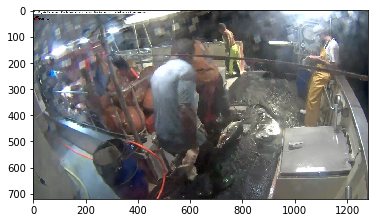

In [7]:
path = PATH/"train/ALB/img_02140.jpg"
im = read_image(path)
plt.imshow(im)

In [8]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(720, 1280, 3)

In [9]:
# let's look at the typical size of these images
files = list((PATH/"train/ALB/").iterdir()) + list((PATH/"train/SHARK/").iterdir())
dims = [read_image(str(p)).shape for p in files]
counts = Counter(dims)
counts

Counter({(720, 1280, 3): 1163,
         (854, 1518, 3): 6,
         (670, 1192, 3): 164,
         (750, 1280, 3): 330,
         (974, 1280, 3): 87,
         (718, 1276, 3): 109,
         (924, 1280, 3): 34,
         (700, 1244, 3): 2})

In [10]:
[(k[1]/k[0], counts[k]) for k in counts] 

[(1.7777777777777777, 1163),
 (1.7775175644028103, 6),
 (1.7791044776119402, 164),
 (1.7066666666666668, 330),
 (1.3141683778234086, 87),
 (1.777158774373259, 109),
 (1.3852813852813852, 34),
 (1.7771428571428571, 2)]

## Resizing images

In [11]:
paths = sorted([x for x in list((PATH/"train").iterdir()) if x.is_dir()])
paths

[PosixPath('/data2/yinterian/fisheries/train/ALB'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/YFT')]

In [12]:
## all files
files = [f for d in paths for f in list(d.iterdir())]
len(files)
files[-3:]

[PosixPath('/data2/yinterian/fisheries/train/YFT/img_00783.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_02756.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_05644.jpg')]

In [13]:
# here is how you get the class
files[0].parts[-2]

'ALB'

In [14]:
labels = [p.parts[-1] for p in paths]
labels

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [15]:
{v:k for k, v in enumerate(labels)}

{'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}

In [16]:
def resize_images(path, sz=300):
    im = read_image(path)
    sz2 = int(1.778*sz)
    return cv2.resize(im, (sz2, sz))

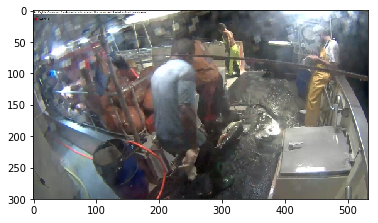

In [17]:
path = PATH/"train/ALB/img_02140.jpg"
im = resize_images(path)
plt.imshow(im)

In [18]:
train_path = PATH/"train-300"
valid_path = PATH/"valid-300"

train_path.mkdir(exist_ok=True)
valid_path.mkdir(exist_ok=True) 

In [19]:
def resize_all_images(train_path, valid_path, org_path, sz=300):
    np.random.seed(3)
    paths = [x for x in list(org_path.iterdir()) if x.is_dir()]
    for p in paths:
        label = p.parts[-1]
        (train_path/label).mkdir(exist_ok=True)
        (valid_path/label).mkdir(exist_ok=True) 
        files = list((org_path/label).iterdir())
        for f in files:
            f_name = f.parts[-1]
            if np.random.uniform() < 0.8:
                new_path = train_path/label/f_name
            else:
                new_path = valid_path/label/f_name
            im = resize_images(f)
            cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [20]:
#run just the first time
#resize_all_images(train_path, valid_path, PATH/"train")

In [21]:
# checking
for label in labels:
    all_files = len(list((PATH/"train"/label).iterdir()))
    train_files = len(list((train_path/label).iterdir()))
    valid_files = len(list((valid_path/label).iterdir()))
    print(label, all_files, train_files, valid_files)

ALB 1719 1377 342
BET 200 161 39
DOL 117 100 17
LAG 67 61 6
NoF 465 373 92
OTHER 299 233 66
SHARK 176 145 31
YFT 734 587 147


## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks. For this problem we cannot crop much because we may leave the fish out.

In [3]:
# modified from fast.ai

import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Resize, horizontal and vertical translations

(300, 533, 3)


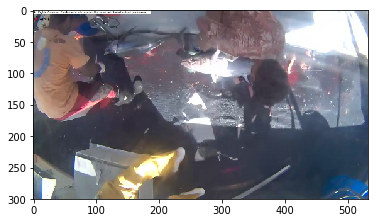

In [22]:
path = PATH/"train-300/ALB/img_03017.jpg"
im = read_image(path)
im2 = random_crop(im)
plt.imshow(im)
print(im.shape)

(284, 505, 3)

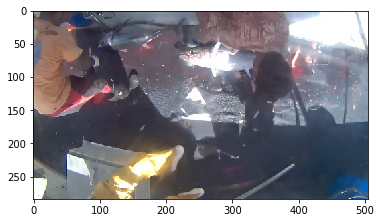

In [23]:
plt.imshow(im2)
im2.shape

### Random Rotation (-10, 10) 

-9.64058941100202


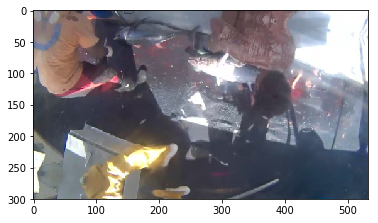

In [24]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

### Horizontal Flip

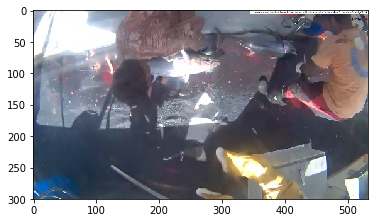

In [25]:
im_f = np.fliplr(im)
plt.imshow(im_f)

## Dataset

In [4]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [9]:
class FishDataset(Dataset):
    def __init__(self, PATH, train="train-300", transforms=False):
        self.path_to_images = PATH/train
        self.transforms = transforms
        self.paths = sorted([x for x in list(self.path_to_images.iterdir()) if x.is_dir()])
        self.files = [f for d in self.paths for f in list(d.iterdir())]
        self.labels = [p.parts[-1] for p in self.paths]
        self.label2ind = {v:k for k,v in enumerate(self.labels)}
        self.len = len(self.files)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        path = self.files[idx] 
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [10]:
train_ds = FishDataset(PATH, "train-300", transforms=True)
valid_ds = FishDataset(PATH, "valid-300")

In [11]:
len(train_ds), len(valid_ds)

(3037, 740)

In [12]:
batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [13]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [14]:
x.shape,y

((3, 284, 505), 0)

In [15]:
x,y = next(iter(valid_dl))
x.shape

torch.Size([10, 3, 284, 505])

In [16]:
x, y = valid_ds[0]
x.shape

(3, 284, 505)

## Model

In [40]:
resnet = models.resnet34(pretrained=True)
#resnet 

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]])
        self.groups.append(nn.Linear(512, 8))

    def forward(self, x):
        for group in self.groups[:2]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x)
        return x
    
    def freeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self,  group_idx:int):
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [37]:
model = Net().cuda()

In [38]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([10, 3, 284, 505]), torch.Size([10]))

In [39]:
x = x.cuda().float()
y = y.cuda()

In [40]:
y

tensor([1, 0, 7, 6, 7, 1, 0, 2, 4, 7], device='cuda:0')

In [41]:
y_hat = model(x)
y_hat

tensor([[ 1.0628, -0.0233, -0.1084,  0.3806,  1.2067,  0.9600, -1.2378,  0.8523],
        [ 1.0742, -0.3971, -0.1576,  0.8710,  0.8529,  0.8118, -1.0600,  1.0675],
        [ 1.5812, -0.0858, -0.4314,  0.3892,  0.9508,  0.3697, -0.5257,  1.0444],
        [ 0.8962, -0.2552,  0.0547,  1.0643,  1.2311,  0.6274, -1.2280,  0.8521],
        [ 1.3461,  0.1037, -0.4164,  0.5736,  0.8834,  0.6929, -0.7160,  0.8794],
        [ 1.1651, -0.1165, -0.6657,  0.5705,  0.9855,  1.0431, -1.1357,  1.0923],
        [ 1.7395,  0.2245, -0.6981,  0.3947,  0.8416,  0.2801, -1.0383,  1.0898],
        [ 0.9162, -0.0915, -0.7562,  0.3025,  1.2256,  0.7692, -1.0550,  1.1303],
        [ 1.4245, -0.3728, -0.5236,  0.4522,  0.0669,  1.1260, -0.8458,  0.4568],
        [ 1.5519,  0.0759, -0.6907,  0.4551,  0.9646,  0.5431, -0.7777,  0.8919]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [42]:
# hard prediction
_, pred = torch.max(y_hat, 1)
pred

tensor([4, 0, 0, 4, 0, 0, 0, 4, 0, 0], device='cuda:0')

In [43]:
y

tensor([1, 0, 7, 6, 7, 1, 0, 2, 4, 7], device='cuda:0')

In [44]:
pred.eq(y).sum()

tensor(2, device='cuda:0')

In [45]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.cross_entropy(y_hat, y).item()

2.338528633117676

In [25]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [48]:
val_metrics(model, valid_dl)

(1.8033424760844257, 0.33918918918918917)

## Learning rate finder

In [18]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)]
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, [lr0/9, lr0/3, lr0] )]
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [19]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.05, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    optimizer = create_optimizer(model, lrs[0])
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [79]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [80]:
model = Net().cuda()
model.unfreeze(1)
model.unfreeze(0)
lrs, losses = LR_range_finder(model, train_dl)

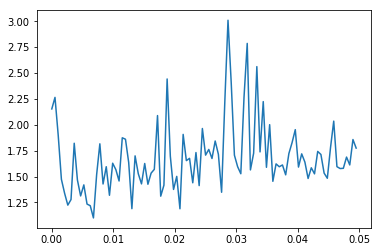

In [81]:
plt.plot(lrs, losses)
plt.show()

## One cycle rate training

In [20]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [64]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            if idx == int(0.2*iterations):
                model.unfreeze(0)
                print(idx, "unfreezing 0")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.9:
                path = "{0}/models/model_resnet34_loss_{1:.0f}.pth".format(PATH, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

## Training with one-cycle policy

In [22]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
model = Net().cuda()

In [62]:
val_metrics(model, valid_dl)

val loss 2.090 and accuracy 0.107


In [54]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs=30)

train_loss 1.568 val_loss 1.351 val_acc 0.486
/data2/yinterian/fisheries/models/model_resnet34_loss_49.pth
train_loss 1.321 val_loss 1.167 val_acc 0.601
/data2/yinterian/fisheries/models/model_resnet34_loss_60.pth
285 unfreezing 1
train_loss 1.102 val_loss 0.993 val_acc 0.647
/data2/yinterian/fisheries/models/model_resnet34_loss_65.pth
train_loss 1.092 val_loss 2.285 val_acc 0.501
train_loss 0.762 val_loss 4.551 val_acc 0.407
570 unfreezing 0
train_loss 0.642 val_loss 1.026 val_acc 0.622
train_loss 0.780 val_loss 1.253 val_acc 0.561
train_loss 0.668 val_loss 0.934 val_acc 0.727
/data2/yinterian/fisheries/models/model_resnet34_loss_73.pth
train_loss 0.566 val_loss 1.592 val_acc 0.627
train_loss 0.525 val_loss 0.484 val_acc 0.846
/data2/yinterian/fisheries/models/model_resnet34_loss_85.pth
train_loss 0.360 val_loss 0.616 val_acc 0.832
train_loss 0.286 val_loss 0.894 val_acc 0.731
train_loss 0.314 val_loss 0.775 val_acc 0.768
train_loss 0.280 val_loss 0.632 val_acc 0.792
train_loss 0.216 

0.005752199762437958

In [63]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.005, epochs=30)

train_loss 1.646 val_loss 1.484 val_acc 0.473
train_loss 1.436 val_loss 1.327 val_acc 0.534
285 unfreezing 1
train_loss 1.270 val_loss 1.167 val_acc 0.615
train_loss 0.732 val_loss 0.964 val_acc 0.699
train_loss 0.538 val_loss 0.760 val_acc 0.765
570 unfreezing 0
train_loss 0.460 val_loss 0.443 val_acc 0.855
train_loss 0.565 val_loss 0.875 val_acc 0.714
train_loss 0.470 val_loss 0.644 val_acc 0.812
train_loss 0.349 val_loss 0.474 val_acc 0.839
train_loss 0.319 val_loss 0.691 val_acc 0.769
train_loss 0.260 val_loss 0.227 val_acc 0.935
/data2/yinterian/fisheries/models/model_resnet34_loss_94.pth
train_loss 0.186 val_loss 0.271 val_acc 0.916
train_loss 0.145 val_loss 0.490 val_acc 0.872
train_loss 0.168 val_loss 0.382 val_acc 0.873
train_loss 0.173 val_loss 0.401 val_acc 0.893
train_loss 0.100 val_loss 0.181 val_acc 0.957
/data2/yinterian/fisheries/models/model_resnet34_loss_96.pth
train_loss 0.068 val_loss 0.287 val_acc 0.915
train_loss 0.056 val_loss 0.171 val_acc 0.954
/data2/yinterian

0.002179509760460954

In [65]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.001, epochs=30)

train_loss 1.668 val_loss 1.574 val_acc 0.458
train_loss 1.580 val_loss 1.508 val_acc 0.458
285 unfreezing 1
train_loss 1.489 val_loss 1.408 val_acc 0.480
train_loss 0.686 val_loss 0.421 val_acc 0.858
train_loss 0.228 val_loss 0.357 val_acc 0.882
570 unfreezing 0
train_loss 0.171 val_loss 0.497 val_acc 0.836
train_loss 0.181 val_loss 0.192 val_acc 0.946
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.132 val_loss 0.568 val_acc 0.816
train_loss 0.124 val_loss 0.350 val_acc 0.891
train_loss 0.121 val_loss 0.203 val_acc 0.950
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.065 val_loss 0.189 val_acc 0.949
train_loss 0.052 val_loss 0.303 val_acc 0.919
train_loss 0.058 val_loss 0.192 val_acc 0.950
train_loss 0.047 val_loss 0.183 val_acc 0.954
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.038 val_loss 0.168 val_acc 0.968
/data2/yinterian/fisheries/models/model_resnet34_loss_97.pth
train_loss 0.019 val_loss 0.180 

0.0005591723493161692

## Bounding boxes and multi-task learning
A kaggle user has created bounding boxes for each fish in the training set. [Here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902) is a link to download them. We will use the bounding boxes by training a model to not only predict the class of the fish but also the bounding box.

### Transfoms with bounding boxes

In [67]:
def make_bb_px(y, x_shape):
    """ Makes an image of size x retangular bounding box"""
    r,c,*_ = x_shape 
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y

def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [68]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [69]:
def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

In [70]:
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = make_bb_px(bb, x.shape)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, to_bb(Y)

In [266]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

In [71]:
def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [101]:
path = PATH/"train-300/DOL/img_01185.jpg"

In [102]:
path.parts[-1], path.parts[-2]

('img_01185.jpg', 'DOL')

In [74]:
import pickle
with open(PATH/'bb_json_300.pkl','rb') as f:
    bb_json_300 = pickle.load(f)

In [80]:
im = cv2.imread(str(path))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
bb = bb_json_300["img_01185.jpg"]

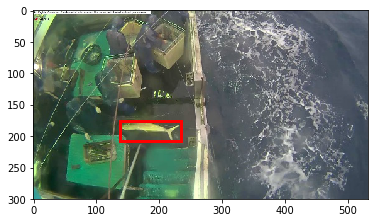

In [81]:
show_corner_bb(im, bb)

In [82]:
im_t, bb_t = transformsXY(path, bb, True)

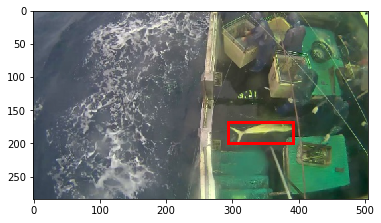

In [83]:
show_corner_bb(im_t, bb_t)

## New dataset
Here I have to start with the larger dataset because I need to transform x and y at the same time.

In [84]:
with open(PATH/'bb_json_300.pkl','rb') as f:
    bb_json_300 = pickle.load(f)

In [98]:
def get_files(path=PATH/"train-300"):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [99]:
train_files = get_files()
valid_files = get_files(PATH/"valid-300")

In [278]:
path=PATH/"train-300"
paths = [d for d in list(path.iterdir()) if d.is_dir()]
labels = [p.parts[-1] for p in paths]
labels

['DOL', 'NoF', 'LAG', 'SHARK', 'OTHER', 'BET', 'YFT', 'ALB']

In [274]:
{v:k for k,v in enumerate(labels)}

{'DOL': 0,
 'NoF': 1,
 'LAG': 2,
 'SHARK': 3,
 'OTHER': 4,
 'BET': 5,
 'YFT': 6,
 'ALB': 7}

In [279]:
class FishDataset2(Dataset):
    def __init__(self, files, bb_json=bb_json_300, transforms=False, labels=labels):
        self.transforms = transforms
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.bb_json = bb_json
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        bb_exist = 0
        if name in self.bb_json:
            bb = self.bb_json[name]
            bb_exist = 1
        else:
            bb = np.zeros(4)
        x, y_bb = transformsXY(path, bb, self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb, bb_exist

In [110]:
train_ds2 = FishDataset2(train_files, transforms=True)
valid_ds2 = FishDataset2(valid_files)

In [111]:
x, y_class, y_bb, bb_exist = train_ds2[20]
x.shape, y_class, y_bb, bb_exist

((3, 284, 505), 0, array([161., 269., 207., 361.], dtype=float32), 1)

In [138]:
batch_size = 10
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
valid_dl2 = DataLoader(valid_ds2, batch_size=batch_size)

## Model

In [114]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]])
        self.linears = nn.ModuleList([nn.Linear(512, 8), nn.Linear(512, 4)])
        self.groups.append(self.linears)

    def forward(self, x):
        for group in self.groups[:2]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x1 = self.linears[0](x)
        x2 = self.linears[1](x)
        return x1, x2
    
    def freeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self,  group_idx:int):
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [115]:
net = Net2().cuda()

In [118]:
# parameters for Group 3
[p.shape for p in net.groups[2].parameters()]

[torch.Size([8, 512]), torch.Size([8]), torch.Size([4, 512]), torch.Size([4])]

In [139]:
x, y1, y2, z = next(iter(train_dl2))

In [140]:
y1 = y1.cuda()
y2 = y2.cuda()
out_class, out_bb = net(x.float().cuda())

In [141]:
y1.long()

tensor([1, 7, 7, 7, 6, 7, 6, 4, 1, 7], device='cuda:0')

In [142]:
F.cross_entropy(out_class, y1.long())

tensor(1.9422, device='cuda:0', grad_fn=<NllLossBackward>)

In [143]:
F.l1_loss(out_bb, y2.float()).item()

155.6977996826172

In [161]:
F.l1_loss(out_bb, y2.float(), reduction="sum").item()

6227.912109375

In [144]:
# loss per observation
F.l1_loss(out_bb, y2.float(), reduction="none")

tensor([[1.0033e+00, 2.8905e-01, 7.5730e-01, 2.1005e+00],
        [1.2700e+02, 1.4139e+02, 1.5736e+02, 2.1175e+02],
        [2.1923e+02, 2.4922e+02, 2.3197e+02, 2.8399e+02],
        [1.8035e+02, 2.5350e+02, 2.6570e+02, 3.2603e+02],
        [1.4063e+02, 1.4617e+02, 2.0269e+02, 2.4686e+02],
        [1.7807e+02, 2.0328e+02, 2.6953e+02, 2.6450e+02],
        [1.3138e+02, 4.4626e+01, 1.9965e+02, 1.7676e+02],
        [6.6284e-01, 3.8952e-01, 7.5256e-01, 1.6761e+00],
        [1.3093e+00, 4.2092e-02, 3.9832e-01, 1.7253e+00],
        [1.6787e+02, 4.5220e+02, 2.4821e+02, 4.9691e+02]], device='cuda:0',
       grad_fn=<L1LossBackward>)

In [156]:
# here is an issue not all images have a bounding box
z = z.cuda().float()
z

tensor([0., 1., 1., 1., 1., 1., 1., 0., 0., 1.], device='cuda:0')

In [157]:
z.sum()

tensor(7., device='cuda:0')

In [158]:
F.l1_loss(out_bb, y2.float(), reduction="none").sum(1).shape

torch.Size([10])

In [155]:
z*F.l1_loss(out_bb, y2.float(), reduction="none").sum(1)

tensor([   0.0000,  637.4985,  984.4034, 1025.5848,  736.3495,  915.3776,
         552.4091,    0.0000,    0.0000, 1365.1829], device='cuda:0',
       grad_fn=<MulBackward0>)

In [160]:
l = z*F.l1_loss(out_bb, y2.float(), reduction="none").sum(1)
l.sum()/z.sum()

tensor(888.1151, device='cuda:0', grad_fn=<DivBackward0>)

In [188]:
def val_metrics2(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb, z in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        z = z.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = z*F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [170]:
val_metrics2(net, valid_dl2)

(2.4916286159206082, 0.21351351351351353)

## Training v2

In [191]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.01, epochs=10, C=1000):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb, z in train_dl:
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            z = z.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = z*F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            if idx == int(0.2*iterations):
                model.unfreeze(0)
                print(idx, "unfreezing 0")
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics2(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.9:
                path = "{0}/models/model_resnet34_loss_{1:.0f}.pth".format(PATH, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [192]:
net = Net2().cuda()

In [193]:
batch_size = 32
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
valid_dl2 = DataLoader(valid_ds2, batch_size=batch_size)

In [194]:
val_metrics2(net, valid_dl2)

(2.9315884615923906, 0.1527027027027027)

In [195]:
train_triangular_policy2(net, train_dl2, valid_dl2, max_lr=0.001, epochs=10)

95 unfreezing 1
train_loss 2.443 val_loss 2.085 val_acc 0.489
190 unfreezing 0
train_loss 1.300 val_loss 0.980 val_acc 0.839
train_loss 0.802 val_loss 0.779 val_acc 0.873
train_loss 0.597 val_loss 0.446 val_acc 0.947
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.408 val_loss 0.390 val_acc 0.953
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.266 val_loss 0.322 val_acc 0.962
/data2/yinterian/fisheries/models/model_resnet34_loss_96.pth
train_loss 0.225 val_loss 0.293 val_acc 0.968
/data2/yinterian/fisheries/models/model_resnet34_loss_97.pth
train_loss 0.193 val_loss 0.277 val_acc 0.969
/data2/yinterian/fisheries/models/model_resnet34_loss_97.pth
train_loss 0.183 val_loss 0.268 val_acc 0.974
/data2/yinterian/fisheries/models/model_resnet34_loss_97.pth
train_loss 0.184 val_loss 0.269 val_acc 0.972


0.18421286762565384

In [199]:
net = Net2().cuda()
train_triangular_policy2(net, train_dl2, valid_dl2, max_lr=0.001, epochs=10, C=500)

95 unfreezing 1
train_loss 2.962 val_loss 2.706 val_acc 0.458
190 unfreezing 0
train_loss 1.903 val_loss 1.402 val_acc 0.851
train_loss 1.303 val_loss 1.122 val_acc 0.891
train_loss 0.952 val_loss 0.823 val_acc 0.893
train_loss 0.591 val_loss 0.651 val_acc 0.922
/data2/yinterian/fisheries/models/model_resnet34_loss_92.pth
train_loss 0.486 val_loss 0.499 val_acc 0.966
/data2/yinterian/fisheries/models/model_resnet34_loss_97.pth
train_loss 0.386 val_loss 0.456 val_acc 0.972
/data2/yinterian/fisheries/models/model_resnet34_loss_97.pth
train_loss 0.346 val_loss 0.426 val_acc 0.976
/data2/yinterian/fisheries/models/model_resnet34_loss_98.pth
train_loss 0.331 val_loss 0.423 val_acc 0.974
train_loss 0.326 val_loss 0.420 val_acc 0.976


0.325989962173678

In [198]:
train_triangular_policy2(net, train_dl2, valid_dl2, max_lr=0.001, epochs=20)

train_loss 0.217 val_loss 0.375 val_acc 0.931
/data2/yinterian/fisheries/models/model_resnet34_loss_93.pth
190 unfreezing 1
train_loss 0.203 val_loss 0.372 val_acc 0.920
train_loss 0.209 val_loss 0.381 val_acc 0.914
380 unfreezing 0
train_loss 0.212 val_loss 0.394 val_acc 0.922
train_loss 0.220 val_loss 0.386 val_acc 0.930
train_loss 0.197 val_loss 0.471 val_acc 0.909
train_loss 0.214 val_loss 0.359 val_acc 0.942
/data2/yinterian/fisheries/models/model_resnet34_loss_94.pth
train_loss 0.178 val_loss 0.342 val_acc 0.945
/data2/yinterian/fisheries/models/model_resnet34_loss_94.pth
train_loss 0.148 val_loss 0.466 val_acc 0.916
train_loss 0.154 val_loss 0.330 val_acc 0.942
train_loss 0.151 val_loss 0.356 val_acc 0.949
/data2/yinterian/fisheries/models/model_resnet34_loss_95.pth
train_loss 0.135 val_loss 0.329 val_acc 0.942
train_loss 0.119 val_loss 0.365 val_acc 0.945
train_loss 0.111 val_loss 0.326 val_acc 0.959
/data2/yinterian/fisheries/models/model_resnet34_loss_96.pth
train_loss 0.103 

0.09267630575517309

## Making predictions

In [237]:
net = Net2().cuda()
model_path = PATH/"models/model_resnet34_loss_98.pth"
load_model(net, model_path)
val_metrics2(net, valid_dl2)

(0.26739096021330033, 0.9756756756756757)

In [256]:
# making predictions
path = PATH/"train-300/ALB/img_01160.jpg"
test_ds = FishDataset2([path])
x, y_class, y_bb, z = test_ds[0]

In [257]:
x.shape

(3, 284, 505)

In [258]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 505])

In [259]:
out_class, out_bb = net(xx.cuda())
out_class, out_bb

(tensor([[-4.4865, -6.1676, -2.2141, -4.0761, -3.7696, -3.7672, -0.7337, 11.4604]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[131.2023, 236.9773, 212.2091, 319.0399]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [260]:
torch.max(out_class, 1)

(tensor([11.4604], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([7], device='cuda:0'))

In [261]:
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
bb_hat

array([[131, 236, 212, 319]])

In [263]:
bb = bb_json_300["img_01160.jpg"]
bb

array([176., 273., 260., 312.], dtype=float32)

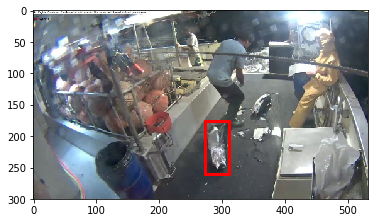

In [264]:
im = cv2.imread(str(path))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, bb)

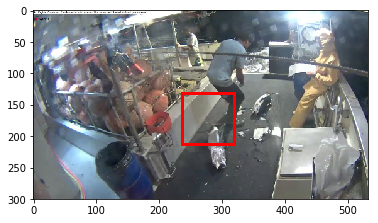

In [272]:
show_corner_bb(im, bb_hat[0])

# References
This notebook is based on the Keras implementation from [fast.ai](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson7.ipynb).